# Introduction

### **Limitations of Lexical Retrievers (e.g., TF-IDF)**


While lexical retrievers like the proposed TF-IDF method are efficient and straightforward, relying solely on them has several inherent limitations:

- **Vocabulary Mismatch:**  
  Lexical retrievers depend on exact or partial word matches between the query and documents.  
  If the query contains words not present in any product title or description, relevant items may be completely missed.  

- **Misspellings and Typos:**  
  Lexical models struggle with spelling errors or typos. For example, a search for “iphon” instead of “iPhone” may fail to retrieve relevant products because the misspelled term doesn't match any indexed words.  

- **Synonymy and Paraphrasing:**  
  Users may express the same intent using different words, such as “couch” vs. “sofa.” Lexical retrievers lack the ability to recognize these semantic equivalences.

- **Overreliance on Rare Terms:**  
  Lexical models often assign disproportionate weight to uncommon words, potentially producing overly narrow or skewed results.  
  For example, as it can be seen in the following image, for the query `turquoise pillow`, the TF-IDF method achieves only a **MAP@10 score of 0.16** because it overly-focus on the _extrange_ word `turquoise`.

<br>

<figure style="text-align: center;">
  <img src="./static/TFIDF_issue_example.png" alt="tfidf_overreliance_on_rare_terms" width="1300"/>
  <figcaption style="font-size: 10px; font-style: italic;">TFIDF overrelizance on rare terms example</figcaption>
</figure>

<br>

For these reasons, lexical retrieval alone is often insufficient for a robust e-commerce search system. Complementing it with dense retrieval methods or hybrid approaches helps address these challenges by capturing semantic meaning, handling noisy input, and improving overall recall and ranking quality.

<br>

### Possible Enhancements

To improve the current retrieval method, several enhancements can be considered:

<br>

3. **Retain Lexical Retriever and Add a Neural Re-Ranker** <br>
Keeping the lexical retriever for efficiency, a **neural re-ranking model** (e.g., cross-encoder) can be added as a second step.  
This cascaded approach combines high efficiency from the first stage with improved precision from the re-ranker, which evaluates a smaller candidate set (e.g., top 100 results) by considering contextual and semantic nuances of each query-document pair.


1.  **Utilize More Advanced Lexical Retrieval Algorithms** <br>
While TF-IDF provides a strong and interpretable baseline, it can be improved by switching to more advanced lexical retrieval methods such as **BM25**.

2. **Utilize a Dense Retriever** <br>
Replacing the sparse TF-IDF retriever with a dense retrieve, such as those based on sentence embeddings from transformer models (e.g., BGE family), allows mapping queries and documents into a continuous vector space. Semantic similarity is then measured via cosine similarity. Dense retrieval captures deeper semantic relationships beyond mere term overlap.

3. **Hybrid Retrieval** <br>
A **hybrid retriever** mixes complementary strengths of lexical (TF-IDF) and dense retrieval systems, for example via weighted score fusion. Bringing the best of the two previous approaches.

4. **Hybrid Retrieval Followed by Neural Re-Ranking** <br>
Applying hybrid retrieval first, followed by neural re-ranking (e.g., cross-encoder) that will reorder a smaller candidate set (e.g., top 100 results) by considering contextual and semantic nuances of each query-document pair, creates a scalable two-stage pipeline.  
This cascaded approach is likely to improve the precision from the previous proposals.

<br>
<br>

#### Additionally
> With additional time and resources, and given labeled data, dense retrievers can be **fine-tuned** on the target domain, aiming to boost alignment with domain-specific vocabulary and intent. Moreover, one can specialize further by training vertical-specific models per product category (helpful for when product attributes and customer behavior vary significantly across categories like in _fashion_ vs. _electronics_) <br><br> For large-scale production-level search systems, one could implement a **two-tower model architecture** where queries and items are encoded separately. Training uses contrastive objectives like triplet loss to align representations.

<br>

> Introducing a **query rewriting layer**, powered by an LLM, can help normalize or clarify user intent. For example, a vague query like “birthday gift” could be rewritten as “popular gift ideas for 30-year-old woman” (assuming the user is logged in, that information is available, and it can be used).

<br>

> Beyond model-based scoring, production systems often apply a **business logic layer**. These rules modulate rankings based on other criteria, such as inventory levels, margin priorities or time-sensitive promotions. This layer ensures the system not only retrieves relevant items but aligns with business goals and constraints.


⚠️ A system like this can serve different **business goals** (improving click-through rate or driving revenue, etc.) but relevance and response speed will always be essential to user satisfaction. For that reason, each enhancement must be considered in light of the tradeoffs it introduces between **relevance, latency, computational cost, and system complexity**. The best approach will depend on the specific use case, and the goal is always to strike the right balance between those, aligning with both user needs and business priorities.

<br>
<br>

---

# Proposed Implementation

To address this take-home, I propose and built an _ad-hoc_ pipeline that leverages a **Hybrid Retrieval System** followed by a **neural re-ranking** layer.  
Both the dense retrieval and reranking components are implemented using **Cohere's API**, providing a fast way to validate the hypothesis that this architecture improves retrieval metrics over the baseline TF-IDF method.

<br> 

### System Design

Both components of the system are **modularized and containerized in isolation**, allowing for:

- **Decoupled Modifications**  
  Each service can evolve independently. If I decide to switch the reranker to a different model or provider, the retriever remains unaffected and vice versa.

- **Efficient Resource Allocation**  
  This design also anticipates future enhancements. For example, if a service is upgraded to use a fine-tuned model that requires GPU acceleration, it can be hosted on a GPU-enabled machine, while the other components continue running on lightweight infrastructure (e.g., using external APIs or CPU-only nodes).

This setup reflects a practical and scalable approach, keeping the system flexible for production setting.

<br>

### PoC Files Details

To run the retrieval service for this assignment, the following artifacts must be generated beforehand:

1. **TF-IDF matrix**
2. **TF-IDF vectorizer**
3. **FAISS index** for dense embeddings

These can be produced via a bulk ingestion using the `./src/retriever/src/batch_embeddings/pipeline.py` code (running it from .src dir).


If you received these files by email, please proceed to save them under `./src/retriever/src/outputs/`:

- `tfidf_matrix.joblib`
- `tfidf_vectorizer.joblib`
- `products_index.faiss`

<br>
<br>

> ⚠️ **Important**: These files are copied into the Docker image at build time and are **needed** for the retrieval service.  



---
<br>
<br>

# ‼️ Pre-requisites

To run this notebook, please follow these steps:

1. **Set the API Key:**

   - Set your **production** API key from [Cohere](https://cohere.com/) in the following cell
     
> ⚠️ **Warning:** Trial API keys may fail due to quota restrictions, so make sure to use a production key.

In [ ]:
COHERE_API_PRODUCTION_TOKEN = ""

In [2]:
# Here I generate the needed env files for the retriever and reranker
# Make sure to set the COHERE_API_PRODUCTION_TOKEN variable before running this script


if not COHERE_API_PRODUCTION_TOKEN:
    raise ValueError(
        "Please set the COHERE_API_PRODUCTION_TOKEN variable before running this script."
    )


# clone the git repo that contains the data and additional information about the dataset
import os
if not os.path.isdir("WANDS"):
    !git clone https://github.com/wayfair/WANDS.git
else:
    print("✅ 'WANDS' directory already exists, skipping clone.")


ENV = "dev"
ARTIFACTS_SAVE_PATH = "./outputs/"
DATA_PATH = "../../../WANDS/dataset/product.csv"

with open("./src/retriever/.env", "w") as f:
    f.write(f"""\
    ENV={ENV}
    COHERE_API_KEY={COHERE_API_PRODUCTION_TOKEN}
    ARTIFACTS_SAVE_PATH={ARTIFACTS_SAVE_PATH}
    DATA_PATH={DATA_PATH}
""")

with open("./src/reranker/.env", "w") as f:
    f.write(f"""\
    ENV={ENV}
    COHERE_API_KEY={COHERE_API_PRODUCTION_TOKEN}
""")

✅ 'WANDS' directory already exists, skipping clone.


2. **Prepare needed files:**

- Please proceed to save under `./src/retriever/src/outputs/` the files you received via email:

    - `tfidf_matrix.joblib`
    - `tfidf_vectorizer.joblib`
    - `products_index.faiss`

In [3]:
output_dir = "./src/retriever/src/outputs/"
assert os.path.isdir(output_dir), f"Output directory does not exist: {output_dir}"

required_files = [
    "tfidf_matrix.joblib",
    "tfidf_vectorizer.joblib",
    "products_index.faiss"
]

for filename in required_files:
    file_path = os.path.join(output_dir, filename)
    assert os.path.isfile(file_path), f"Missing required file: {file_path}"

3. **Start the Docker Containers:**

   - Use the `docker-compose.yml` file located at the root directory of the project to spin up containers for both the retriever and reranker services.  
   - Notice both 8000 and 8080 ports will be used to expose the APIs
   - ⬇️You can run the following cell to spinup the containers

In [4]:
!docker-compose up -d

[+] Building 0.0s (0/0)  docker:desktop-linux
[+] Building 0.0s (0/1)                                    docker:desktop-linux
[+] Building 0.2s (1/2)                                    docker:desktop-linux
 => [rerank-system internal] load build definition from Dockerfile         0.0s
 => => transferring dockerfile: 499B                                       0.0s
 => [rerank-system internal] load metadata for docker.io/library/python:3  0.2s
[+] Building 0.3s (1/2)                                    docker:desktop-linux
 => [rerank-system internal] load build definition from Dockerfile         0.0s
 => => transferring dockerfile: 499B                                       0.0s
 => [rerank-system internal] load metadata for docker.io/library/python:3  0.3s
[+] Building 0.5s (1/2)                                    docker:desktop-linux
 => [rerank-system internal] load build definition from Dockerfile         0.0s
 => => transferring dockerfile: 499B                                      

Let's check both containers are running correctly

In [5]:
import subprocess

def is_container_running(name):
    try:
        result = subprocess.run(
            ["docker", "inspect", "-f", "{{.State.Running}}", name],
            capture_output=True, text=True, timeout=3
        )
        return result.stdout.strip() == "true"
    except Exception as e:
        print(f"Error checking container '{name}': {e}")
        return False

containers = ["retrieval-system-backend", "rerank-system-backend"]

for name in containers:
    if not is_container_running(name):
        raise RuntimeError(f"Assertion failed: '{name}' is not running")

print("Assertion passed: all required containers are running.")

Assertion passed: all required containers are running.


---
# Environment Setup


Before we begin, we will:

- Install and import the required libraries,
- Set up the necessary environment variables, and
- Download and load the WANDS dataset

In [6]:
%pip install -q dotenv==0.9.9 httpx==0.28.1 loguru==0.7.3 matplotlib==3.10.3 numpy==2.2.6 pandas==2.3.0 scikit-learn==1.7.0 tqdm==4.67.1

Note: you may need to restart the kernel to use updated packages.


In [7]:
RETRIEVE_IDS_URL = "http://localhost:8000/retrieval/retrieve_ids"
RETRIEVE_DOCS_URL = "http://localhost:8000/retrieval/retrieve_docs"
RANK_DOCS_URL = "http://localhost:8080/rerank/rerank_get_docs"

In [8]:
import dotenv

dotenv.load_dotenv("./src/retriever/.env")

True

In [9]:
import asyncio
import os
from typing import List, Optional, Tuple

import httpx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loguru import logger
from scipy.sparse._csr import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [10]:
# get search queries
query_df = pd.read_csv("WANDS/dataset/query.csv", sep="\t")
# get products
product_df = pd.read_csv("WANDS/dataset/product.csv", sep="\t")
# get manually labeled groundtruth lables
label_df = pd.read_csv("WANDS/dataset/label.csv", sep="\t")

# group the labels for each query to use when identifying exact matches
grouped_label_df = label_df.groupby("query_id")

---
# TFIDF Functions

In this section the functions to enable the TF-IDF method are defined.

### Implementation modification:

- In the given seed code, the text used to generate embeddings was generated by concatenating `dataframe['product_name'] + ' ' + dataframe['product_description']`.  
- This approach has a subtle issue: if **either column contains NaN values**, the entire concatenated text becomes `NaN`. When `.values.astype('U')` is applied before fitting the TF-IDF vectorizer, this `NaN` is converted to the literal string `"nan"`.  
- As a result, the vectorizer creates a vector for that entry based on the meaningless token `"nan"`, producing an unusable representation that will never be retrieved.  

### Proposed fix:

To avoid this issue, I replaced that line with: `dataframe[['product_name', 'product_description']].fillna("").agg(" ".join, axis=1)`

In [11]:
def calculate_tfidf(dataframe: pd.DataFrame) -> Tuple[TfidfVectorizer, csr_matrix]:
    """
    Calculate the TF-IDF for combined product name and description.

    Parameters:
    dataframe (pd.DataFrame): DataFrame with product_id, and other product information.

    Returns:
    Tuple[TfidfVectorizer, csr_matrix]: TF-IDF vectorizer and TF-IDF matrix.
    """
    combined_text = (
        dataframe[["product_name", "product_description"]]
        .fillna("")
        .agg(" ".join, axis=1)
    )
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined_text.values.astype("U"))
    return vectorizer, tfidf_matrix


def get_top_products(
    vectorizer: TfidfVectorizer, tfidf_matrix: csr_matrix, query: str, top_n: int = 10
) -> list:
    """
    Get top N products for a given query based on TF-IDF similarity.

    Parameters:
    vectorizer (TfidfVectorizer): Trained TF-IDF vectorizer.
    tfidf_matrix (csr_matrix): TF-IDF matrix for the products.
    query (str): Search query.
    top_n (int): Number of top products to return.

    Returns:
    list: List of top N product IDs.
    """
    query_vector = vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_product_indices = cosine_similarities.argsort()[-top_n:][::-1]
    return top_product_indices

---

## Metrics

A modification has been introduced in the metrics calculation to account for **partial matches**, when intended. An arbitrary score of **0.5** (half of the exact match score) is assigned to partial matches (further discussion on this topic can be found in the _Partial Matches_ section).

In [49]:
def map_at_k(
    true_ids: List[int],
    predicted_ids: List[int],
    partial_true_ids: Optional[List[int]] = None,
    k: int = 10,
) -> float:
    """
    Calculate the Mean Average Precision at K (MAP@K).

    Parameters:
    true_ids (List[int]): List of relevant product IDs.
    predicted_ids (List[int]): List of predicted product IDs.
    partial_true_ids (Optional[List[int]]): List of partial matches product IDs. If provided,
    both Exact and Partial match will be considered for the score calculation.
    k (int): Number of top elements to consider.
             NOTE: IF you wish to change top k, please provide a justification for choosing the new value

    Returns:
    float: MAP@K score.
    """
    if partial_true_ids is None:
        partial_true_ids = []
    if (not len(true_ids) and not len(partial_true_ids)) or not len(predicted_ids):
        return 0.0

    score = 0.0
    num_hits = 0.0

    for i, p_id in enumerate(predicted_ids[:k]):
        if p_id in true_ids:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
        elif p_id in partial_true_ids:
            num_hits += 0.5
            score += num_hits / (i + 1.0)

    max_possible = min(len(true_ids) + 0.5 * len(partial_true_ids), k)
    return score / max_possible if max_possible > 0 else 0.0

### New Metrics Proposal

Even after adding the partial matches scoring to **MAP@K**, it still doesn’t fully capture the differences in how relevant each item actually is from an online user perspective.

That’s where **NDCG@K** has a big advantage. It uses a **logarithmic scale** to give more weight to the top positions — the difference between the first and second spot, for example, is much bigger than between later ones. This is relevant for **business stakeholders** as it matches **real user behavior**: people tend to pay the most attention to the first few results and rarely scroll down. So, by reflecting both **how relevant** an item is and **where** it appears, NDCG@K aligns better with business goals like improving user experience.

That said, metrics like **MAP@K** are usually easier to explain to non-technical stakeholders. So instead of replacing it, I suggest we complement it with **NDCG@K**.

---

Another valuable metric to consider, especially for architectures combining a retriever and a re-ranker, is **Recall@K** for intermediate evaluation.

- **Recall@K** is appropriate here because, when using a composed approach:
  - The **retriever’s role** is to maximize recall, ensuring relevant candidates are retrieved.
  - The **re-ranker’s role** is to improve precision by ordering these candidates effectively.

In [13]:
def dcg_at_k(relevance_scores: List[float], k: int) -> float:
    """
    Compute Discounted Cumulative Gain (DCG) at rank k.

    Args:
        relevance_scores (List[float]): List of relevance scores in rank order (first element is the first item).
        k (int): Rank position to calculate DCG up to.

    Returns:
        float: DCG value at rank k.
    """
    relevance_scores = np.array(relevance_scores[:k])
    if relevance_scores.size == 0:
        return 0.0
    gains = 2 ** relevance_scores - 1
    discounts = np.log2(np.arange(2, 2 + relevance_scores.size))
    return np.sum(gains / discounts)


def ndcg_at_k(
    true_ids: List[int],
    predicted_ids: List[int],
    partial_true_ids: Optional[List[int]] = None,
    k: int = 10,
) -> float:
    """
    Compute NDCG at rank k.

    Args:
        true_ids (List[int]): List of relevant product IDs.
        predicted_ids (List[int]): List of predicted product IDs.
        partial_true_ids (Optional[List[int]]): List of partial matches product IDs. If provided,
        both Exact and Partial match will be considered for the score calculation.
        k (int): Number of top elements to consider.

    Returns:
        float: NDCG@k score, normalized discounted cumulative gain at rank k.
    """
    if partial_true_ids is None:
        partial_true_ids = []
    if (not len(true_ids) and not len(partial_true_ids)) or not len(predicted_ids):
        return 0.0

    relevance_scores = [
        1 if item in true_ids else 0.5 if item in partial_true_ids else 0
        for item in predicted_ids[:k]
    ]

    ideal_relevance = sorted(relevance_scores, reverse=True)

    dcg = dcg_at_k(relevance_scores, k)
    idcg = dcg_at_k(ideal_relevance, k)

    return dcg / idcg if idcg > 0 else 0.0


def recall_at_k(
    true_ids: List[int],
    predicted_ids: List[int],
    partial_true_ids: Optional[List[int]] = None,
    k: int = 10,
) -> float:
    """
    Computes Recall  at rank k.

    Args:
        true_ids (List[int]): List of relevant product IDs.
        predicted_ids (List[int]): List of predicted product IDs.
        partial_true_ids (Optional[List[int]]): List of partial matches product IDs. If provided,
        both Exact and Partial match will be considered for the score calculation.
        k (int): Number of top elements to consider.

    Returns:
        float: Recall@k score
    """
    if partial_true_ids is None:
        partial_true_ids = []
    if (not len(true_ids) and not len(partial_true_ids)) or not len(predicted_ids):
        return 0.0

    true_ids = set(true_ids)
    partial_true_ids = set(partial_true_ids)
    predicted_ids = set(predicted_ids[:k])

    full_hits = len(predicted_ids.intersection(true_ids))
    partial_hits = len(predicted_ids.intersection(partial_true_ids))* 0.5

    total_possible = len(true_ids) + 0.5 * len(partial_true_ids)

    recall_score = (
        (full_hits + partial_hits) / total_possible if total_possible > 0 else 0.0
    )
    return recall_score

---

## Retrieve Function

Since the retriever service runs as a containerized FastAPI endpoint, we need a function to make asynchronous calls to it. The function is defined below.

Details about the retrieval system and its endpoints will be discussed later in the _TFIDF vs Hybrid Retrieval System_ section.

In [14]:
async def retrieve(
    query: str, endpoint_url: str, top_n: int, delay: Optional[int] = 0
) -> list:
    """
    Asynchronously retrieve the top N product IDs for a given query from a specified endpoint.

    Parameters:
        query (str): The search query string.
        endpoint_url (str): The URL of the retrieval endpoint.
        top_n (int): The number of top product IDs to retrieve.
        delay (int, optional): Delay in seconds before making the request (useful for rate limiting). Default is 0.

    Returns:
        list: List of retrieved product IDs.
    """
    await asyncio.sleep(delay)
    async with httpx.AsyncClient(timeout=httpx.Timeout(40)) as client:
        response = await client.post(
            endpoint_url,
            json={"query": query, "top_n": top_n},
        )
    return response.json()

Function Testing

In [15]:
# define the test query
query = "armchair"

# obtain top product IDs
top_product_ids = await retrieve(query, RETRIEVE_IDS_URL, top_n=10)

print(f"Top products for '{query}':")
for product_id in top_product_ids["ids"]:
    product = product_df.loc[product_df["product_id"] == product_id]
    print(product_id, product["product_name"].values[0])

Top products for 'armchair':
40707 33 '' wide armchair
40705 28.5 '' wide armchair
27998 21 '' wide armchair
12756 24.41 '' wide tufted polyester armchair
15687 29 '' wide polyester armchair
14168 18.5 '' wide velvet armchair
14161 26 '' wide velvet armchair
14166 29.5 '' wide velvet armchair
14172 24 '' wide velvet armchair
14149 27.5 '' wide velvet armchair


---

<a id='TFIDF-vs-Hybrid-Retrieval-System'></a>

# TFIDF vs Hybrid Retrieval System

The hybrid retrieval system is hosted within the `semantic-retrieval-engine-retrieval-system` container, which exposes two endpoints:

- `retrieval/retrieve_ids`  
  Given a query, this endpoint returns the **IDs** of the top-N most relevant documents.

- `retrieval/retrieve_docs`  
  Given a query, this endpoint returns the **top-N most relevant documents** themselves.

Here, I'll compare both methods, TFIDF vs Hybrid retrieval. 

First, I’ll run the proposed exact relevant IDs extraction and TF-IDF method functions.

In [16]:
def get_exact_matches_for_query(query_id: int) -> list:
    """Get true label based only in Exact matches

    Args:
        query (str): The search query string.

    Returns:
        list: List of retrieved product IDs.
    """
    query_group = grouped_label_df.get_group(query_id)
    exact_matches = query_group.loc[query_group["label"] == "Exact"][
        "product_id"
    ].values
    return exact_matches


# adding the list of exact match product_IDs from labels_df
query_df["relevant_ids"] = query_df["query_id"].apply(get_exact_matches_for_query)

In [17]:
vectorizer, tfidf_matrix = calculate_tfidf(product_df)


def get_top_product_ids_for_query(query: str) -> list:
    """Get top products based on TF-IDF method.

    Args:
        query (str): The search query string.

    Returns:
        list: List of retrieved product IDs.
    """
    top_product_indices = get_top_products(vectorizer, tfidf_matrix, query, top_n=10)
    top_product_ids = product_df.iloc[top_product_indices]["product_id"].tolist()
    return top_product_ids


# applying the function to obtain top product IDs and adding top K product IDs to the dataframe
query_df["top_product_ids_tfidf"] = query_df["query"].apply(
    get_top_product_ids_for_query
)

Next, I will execute the `retrieve` function for each query (will take less than a minute to complete)

In [19]:
# apply async call to the retrieval endpoint for each query
queries = query_df["query"].tolist()
tasks = [
    retrieve(query, endpoint_url=RETRIEVE_IDS_URL, top_n=10, delay=1)
    for query in queries
]
results = await asyncio.gather(*tasks)
query_df["top_product_ids_hybrid"] = [r["ids"] for r in results]

100%|██████████| 480/480 [00:00<00:00, 263000.12it/s]


Now that we have the results from both `top_product_ids_tfidf` and `top_product_ids_hybrid`, I will calculate the metrics using the functions we defined earlier.

In [50]:
query_df["map@k_tfidf"] = query_df.apply(
    lambda x: map_at_k(x["relevant_ids"], x["top_product_ids_tfidf"], k=10), axis=1
)
query_df["map@k_hybrid"] = query_df.apply(
    lambda x: map_at_k(x["relevant_ids"], x["top_product_ids_hybrid"], k=10), axis=1
)

query_df["ndcg@k_tfidf"] = query_df.apply(
    lambda x: ndcg_at_k(x["relevant_ids"], x["top_product_ids_tfidf"], k=10), axis=1
)
query_df["ndcg@k_hybrid"] = query_df.apply(
    lambda x: ndcg_at_k(x["relevant_ids"], x["top_product_ids_hybrid"], k=10), axis=1
)

query_df["recall@k_tfidf"] = query_df.apply(
    lambda x: recall_at_k(x["relevant_ids"], x["top_product_ids_tfidf"], k=10), axis=1
)
query_df["recall@k_hybrid"] = query_df.apply(
    lambda x: recall_at_k(x["relevant_ids"], x["top_product_ids_hybrid"], k=10), axis=1
)

### Partial Matches

Before comparing the two approaches, it makes sense to include the **partial matched IDs**. 

 * Conceptually, I will asume partial matches can be thought of as **"cart additions"**, whereas exact matches correspond to **"purchases"**.
 
 * Although not as strong as a purchase, in an e-commerce context, cart additions provide a valuable signal of user interest when performing a query.

 * As it was explained in the _Metrics_ section, partial matches will reciebe an arbitrary score of 0.5, while exact match will hace an score of 1.


<h5>Considerations</h5>

Score attribution to different user interactions is rarely perfect. Specifically, a **relative distance problem** arises: for example, if we assign a purchase a score of 1 and a cart addition a score of 0.5, we are implicitly stating that **two cart additions are equivalent to one purchase**.  

This is neither inherently right nor wrong, but such definitions must be validated with business stakeholders to ensure they make sense for the specific use case and align with business objectives.

In [22]:
def get_partial_matches_for_query(query_id: int) -> list:
    """Get true label based only in Partial matches

    Args:
        query (str): The search query string.

    Returns:
        list: List of retrieved product IDs.
    """
    query_group = grouped_label_df.get_group(query_id)
    partial_matches = query_group.loc[query_group["label"] == "Partial"][
        "product_id"
    ].values
    return partial_matches


query_df["relevant_partial_ids"] = query_df["query_id"].apply(
    get_partial_matches_for_query
)

In [51]:
query_df["map@k_tfidf_w_partial"] = query_df.apply(
    lambda x: map_at_k(
        x["relevant_ids"], x["top_product_ids_tfidf"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)
query_df["map@k_hybrid_w_partial"] = query_df.apply(
    lambda x: map_at_k(
        x["relevant_ids"], x["top_product_ids_hybrid"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)

query_df["ndcg@k_tfidf_w_partial"] = query_df.apply(
    lambda x: ndcg_at_k(
        x["relevant_ids"], x["top_product_ids_tfidf"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)
query_df["ndcg@k_hybrid_w_partial"] = query_df.apply(
    lambda x: ndcg_at_k(
        x["relevant_ids"], x["top_product_ids_hybrid"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)

query_df["recall@k_tfidf_w_partial"] = query_df.apply(
    lambda x: recall_at_k(
        x["relevant_ids"], x["top_product_ids_tfidf"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)
query_df["recall@k_hybrid_w_partial"] = query_df.apply(
    lambda x: recall_at_k(
        x["relevant_ids"], x["top_product_ids_hybrid"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)

### Compare

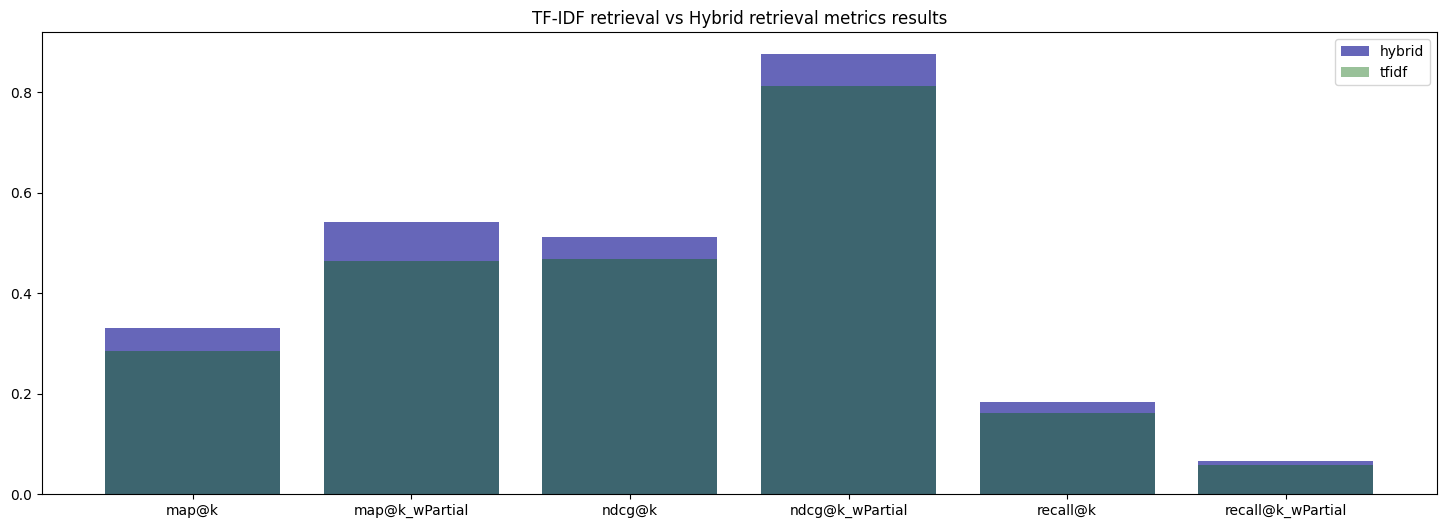

In [52]:
tfidf_metrics = [
    query_df.loc[:, "map@k_tfidf"].mean(),
    query_df.loc[:, "map@k_tfidf_w_partial"].mean(),
    query_df.loc[:, "ndcg@k_tfidf"].mean(),
    query_df.loc[:, "ndcg@k_tfidf_w_partial"].mean(),
    query_df.loc[:, "recall@k_tfidf"].mean(),
    query_df.loc[:, "recall@k_tfidf_w_partial"].mean(),
]

hybrid_metrics = [
    query_df.loc[:, "map@k_hybrid"].mean(),
    query_df.loc[:, "map@k_hybrid_w_partial"].mean(),
    query_df.loc[:, "ndcg@k_hybrid"].mean(),
    query_df.loc[:, "ndcg@k_hybrid_w_partial"].mean(),
    query_df.loc[:, "recall@k_hybrid"].mean(),
    query_df.loc[:, "recall@k_hybrid_w_partial"].mean(),
]


plt.figure(figsize=(18, 6))
plt.bar(
    x=[
        "map@k",
        "map@k_wPartial",
        "ndcg@k",
        "ndcg@k_wPartial",
        "recall@k",
        "recall@k_wPartial",
    ],
    height=hybrid_metrics,
    label="hybrid",
    alpha=0.6,
    color="darkblue",
)

plt.bar(
    x=[
        "map@k",
        "map@k_wPartial",
        "ndcg@k",
        "ndcg@k_wPartial",
        "recall@k",
        "recall@k_wPartial",
    ],
    height=tfidf_metrics,
    label="tfidf",
    alpha=0.4,
    color="darkgreen",
)
plt.title("TF-IDF retrieval vs Hybrid retrieval metrics results")
plt.legend();

The results clearly demonstrate that the **Hybrid method (TFIDF + Cohere’s dense embedding retrieval) outperforms the lexical-only (TFIDF) approach** across **all** the evaluated metrics.  

This highlights the effectiveness of integrating semantic embeddings to capture deeper contextual relevance beyond simple keyword matching.

In both methods (TFIDF & Hybrid) NCDG is higher than MAP, this suggest that the **model is better at putting the most relevant items in the very top positions**.

<br>

Next, I will enhance the hybrid method further by:

- Increasing the number of retrieved items to **100**
- Applying a reranker layer on top of these items to select the **top 10** most relevant results for each query

<br>

---
# Reranker

This service is hosted within the `semantic-retrieval-engine-rerank-system` container, which exposes two endpoints:

- `rerank/rerank_get_ids`  
  Given a query and a set of documents, this endpoint returns the **IDs and scores** of the top-N most relevant documents.

- `rerank/rerank_get_docs`  
  Given a query and a set of documents, this endpoint returns the **top-N most relevant documents** themselves.

<br>

The current implementation leverages **Cohere’s API** to perform the reranking step.  

### Environment Setup

In [54]:
import dotenv

dotenv.load_dotenv("./src/reranker/.env")

True

In [55]:
# To prevent excessive logging from overwhelming the CPU, logging level is set to WARNING, reducing unnecessary output during execution.
import sys

logger.remove()
logger.add(sys.stderr, level="WARNING");

### Reranker Auxiliary Functions

As it was done with the retrieval function, I define a function to call the endpoints exposed by the `semantic-retrieval-engine-rerank-system` container.

<br>

**Consideration**
To avoid running the retrieval function for all queries at once (and to prevent storing the full set of documents in memory, which could be space-intensive)
I propose using a `process_in_batches` function. This function handles the computation in batches, resulting in better memory efficiency during reranking.

In [56]:
async def rerank(
    query: str, documents: list, top_n: int, delay: Optional[int] = 0
) -> dict:
    """
    Rerank a list of documents for a given query using the reranker endpoint.

    Args:
        query (str): The search query string.
        documents (list): List of product IDs or document representations to be reranked.
        top_n (int): Number of top documents to return after reranking.
        delay (Optional[int], optional): Delay in seconds before making the request. Defaults to 0.

    Returns:
        dict: Dictionary containing reranked documents and their scores.
    """
    await asyncio.sleep(delay)
    async with httpx.AsyncClient(timeout=httpx.Timeout(40)) as client:
        response = await client.post(
            RANK_DOCS_URL,
            json={"query": query, "documents": documents, "top_n": top_n},
        )
    return response.json()


async def retrieve_and_rerank(
    query: str, retrieve_top_n: int, rerank_top_n: int
) -> list:
    """
    Retrieve top N documents for a query and rerank them.

    Args:
        query (str): The search query string.
        retrieve_top_n (int): Number of documents to retrieve before reranking.
        rerank_top_n (int): Number of top documents to return after reranking.

    Returns:
        list: List of reranked product IDs.
    """
    documents = await retrieve(
        query, endpoint_url=RETRIEVE_DOCS_URL, top_n=retrieve_top_n, delay=1
    )
    logger.debug("Documents: {}", documents)
    ranked_docs = await rerank(query, documents, rerank_top_n, delay=1)
    logger.debug("Ranked docs: {}", ranked_docs)
    return [x["product_id"] for x in ranked_docs["docs"]]


async def process_in_batches(
    queries: list,
    retrieve_top_n: int,
    rerank_top_n: int,
    batch_size: Optional[int] = 20,
) -> List[List[int]]:
    """
    Process queries in batches, retrieving and reranking documents for each query.

    Args:
        queries (list): List of search query strings.
        retrieve_top_n (int): Number of documents to retrieve before reranking.
        rerank_top_n (int): Number of top documents to return after reranking.
        batch_size (Optional[int], optional): Number of queries to process in each batch. Defaults to 20.

    Returns:
        List[List[int]]: List of lists, where each sublist contains reranked product IDs for a query.
    """
    results = []
    for i in tqdm(range(0, len(queries), batch_size)):
        batch = queries[i : i + batch_size]
        batch_results = await asyncio.gather(
            *(retrieve_and_rerank(q, retrieve_top_n, rerank_top_n) for q in batch)
        )
        results.extend(batch_results)
    return results

### Hybrid vs Hybrid + Rerank retrieval systems

I will run the `process_in_batches` function to retrieve the **top 100** items for each query using the hybrid method.  
Then, I will apply the **reranker** 
to re-score these candidates and extract the **top 10** most relevant results per query.

Finally, I will compute the evaluation metrics as done previously, to assess the impact of the reranking step.

In [57]:
#This will take about 2 minutes to run
queries = query_df["query"].tolist()
results = await process_in_batches(queries, retrieve_top_n=100, rerank_top_n=10)
query_df.loc[:, "reranked_docs"] = results

100%|██████████| 24/24 [02:10<00:00,  5.42s/it]


In [60]:
query_df["map@k_rerank"] = query_df.apply(
    lambda x: map_at_k(x["relevant_ids"], x["reranked_docs"], k=10), axis=1
)
query_df["ndcg@k_rerank"] = query_df.apply(
    lambda x: ndcg_at_k(x["relevant_ids"], x["reranked_docs"], k=10), axis=1
)
query_df["recall@k_rerank"] = query_df.apply(
    lambda x: recall_at_k(x["relevant_ids"], x["reranked_docs"], k=10), axis=1
)
query_df["map@k_rerank_w_partial"] = query_df.apply(
    lambda x: map_at_k(
        x["relevant_ids"], x["reranked_docs"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)
query_df["ndcg@k_rerank_w_partial"] = query_df.apply(
    lambda x: ndcg_at_k(
        x["relevant_ids"], x["reranked_docs"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)
query_df["recall@k_rerank_w_partial"] = query_df.apply(
    lambda x: recall_at_k(
        x["relevant_ids"], x["reranked_docs"], x["relevant_partial_ids"], k=10
    ),
    axis=1,
)

### Compare

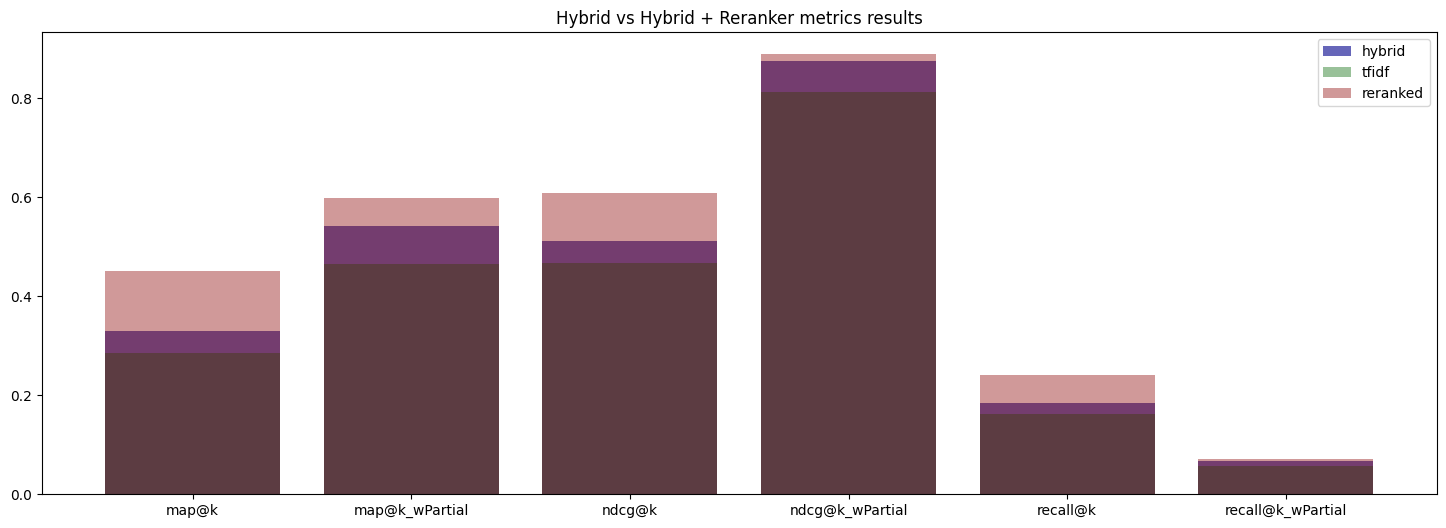

In [61]:
reranked_metrics = [
    query_df.loc[:, "map@k_rerank"].mean(),
    query_df.loc[:, "map@k_rerank_w_partial"].mean(),
    query_df.loc[:, "ndcg@k_rerank"].mean(),
    query_df.loc[:, "ndcg@k_rerank_w_partial"].mean(),
    query_df.loc[:, "recall@k_rerank"].mean(),
    query_df.loc[:, "recall@k_rerank_w_partial"].mean(),
]


plt.figure(figsize=(18, 6))
plt.bar(
    x=[
        "map@k",
        "map@k_wPartial",
        "ndcg@k",
        "ndcg@k_wPartial",
        "recall@k",
        "recall@k_wPartial",
    ],
    height=hybrid_metrics,
    label="hybrid",
    alpha=0.6,
    color="darkblue",
)

plt.bar(
    x=[
        "map@k",
        "map@k_wPartial",
        "ndcg@k",
        "ndcg@k_wPartial",
        "recall@k",
        "recall@k_wPartial",
    ],
    height=tfidf_metrics,
    label="tfidf",
    alpha=0.4,
    color="darkgreen",
)


plt.bar(
    x=[
        "map@k",
        "map@k_wPartial",
        "ndcg@k",
        "ndcg@k_wPartial",
        "recall@k",
        "recall@k_wPartial",
    ],
    height=reranked_metrics,
    label="reranked",
    alpha=0.4,
    color="darkred",
)

plt.title("Hybrid vs Hybrid + Reranker metrics results")
plt.legend();

In [68]:
print(f'TF-IDF MAP@K: {query_df.loc[:, "map@k_tfidf"].mean().round(3)}')
print(f'Hybrid + Reranker MAP@K: {query_df.loc[:, "map@k_rerank"].mean().round(3)}')

TF-IDF MAP@K: 0.285
Hybrid + Reranker MAP@K: 0.452


Finally, the results clearly demonstrate the **significant impact** of the reranker on the system's overall performance, consistently outperforming the Hybrid method across all evaluation metrics, improving base metric by ~60% specifically in MAP@K

This highlights the value of a **composed architecture** in recommender systems, where the **retriever** is optimized for high recall, ensuring a broad pool of relevant candidates,  
and the **reranker** is focused on precision, refining the final results to surface the most relevant items at the top.

---

# Further comments

### **1) Error Handling Logic**

An error-handling mechanism has been implemented to improve the robustness of the retrieval service.

In `src/retriever/src/app/fallbacks/fallback_wrapper.py` and `src/rerank/src/app/fallbacks/fallback_wrapper.py`, you will find:

- A **decorator function** that wraps core logic with error handling,
- A set of **fallback functions** that mimic the expected output format.  
  These serve as temporary placeholders, where other methods (as returning popular products) can be implemented.

This error-handling layer is applied in the service code at:  
`src/retriever/src/app/services/retrieval.py` and `src/reranker/src/app/services/rerank.py`

<br>

While fallback behavior is useful to maintain uptime in production, it’s equally important to treat its usage as a warning sign.

> 🚨 At a production level, **triggering a fallback should raise an alert**, as it may indicate a deeper issue (such as a bug or upstream failure) that requires investigation.


### **2) Engineering for Production**

To ensure this deliverable reflects a robust project, I've incorporated two best practices:

* **Automated Code Quality:**
    * **Pre-commit Hooks:** implemented a **`ruff` hook** to automatically lint and format code before commits.
    * **CI Workflows:** **GitHub Actions** are configured to run `pytest` and `ruff` linting on every `push` or `pull request` to the `main` branch.
* **Testing (v0):**
    * Currently, a dedicated test suite is implemented for the **lexical embedder**.
    * **Placeholders** have been set up for both the **retrieval** and **rerank** modules, allowing for integration of future test suites as these components evolve.

<br>

### **3) Storage**

The current implementation uses **local storage** for files, artifacts, and the FAISS index.  
While this is sufficient for development and testing purposes, it is **not suitable for production environments**.

For production, the system should be adapted to use more scalable and reliable storage solutions, such as:

- **AWS S3** for storing documents, artifacts, and other large assets.
- **AWS RDS** for structured metadata or content storage.
- **Centralized or persistent vector storage** instead of a **local FAISS index**.

<br>

### **4) Batch Transformation Jobs**

It's important to note that the current implementation **does not support incremental processing at embedding the products**.  
Every time the embedding function is executed, it re-generates embeddings for the **entire product database**, which is inefficient and unsuitable for a production environment.

In a production-ready setup, embedding workflows should be **incremental**, processing only new or updated products.

<br>

One approach to achieve this is to implement a scheduled batch processing pipeline using **AWS services**, for example:

- **Amazon EventBridge** to trigger a schedule (e.g., monthly or weekly).
- **AWS Step Functions** to coordinate the embedding generation job (e.g., pulling new products, generating embeddings, and updating the vector store).

---

# Teardown

To completely remove the containers, volumes, and images used in this take-home project, run the following:

In [71]:
!docker-compose down --rmi all --volumes

[+] Running 0/0
 ⠋ Container rerank-system-backend     Stopping                            0.1s 
 ⠋ Container retrieval-system-backend  Stopping                            0.1s 
[+] Running 0/2
 ⠙ Container rerank-system-backend     Stopping                            0.2s 
 ⠙ Container retrieval-system-backend  Stopping                            0.2s 
[+] Running 0/2
 ⠹ Container rerank-system-backend     Stopping                            0.3s 
 ⠹ Container retrieval-system-backend  Stopping                            0.3s 
[+] Running 0/2
 ⠸ Container rerank-system-backend     Stopping                            0.4s 
 ⠸ Container retrieval-system-backend  Stopping                            0.4s 
[+] Running 0/2
 ⠼ Container rerank-system-backend     Stopping                            0.5s 
 ⠼ Container retrieval-system-backend  Stopping                            0.5s 
[+] Running 0/2
 ⠴ Container rerank-system-backend     Stopping                            0.6s 
 ⠴ Container 